In [76]:
import os
import sys
import numpy as np
import scipy, pylab
import scipy.io.wavfile as wave

import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.fftpack import dct
from spectrograms import *
%matplotlib inline

In [77]:
audio_dir = 'audio'
sample_rate = 22050

# we'll work with 3 seconds chunks
chunk_duration = 3     
chunk_duration_samples = sample_rate * chunk_duration    

In [78]:
# read the wave files (ride the wave!)
filenames = os.listdir(audio_dir)
wave_files = [wave.read(os.path.join(audio_dir, name)) for name in filenames]
for i, data in enumerate(wave_files):
    wave_files[i] = normalize_wave(data[1])
    assert data[0], sample_rate

In [79]:
# chop the files
chunks = []
labels = []
for file_index in range(len(filenames)):
    wave_data = wave_files[file_index]
    wave_duration = wave_data.shape[0]/sample_rate
    num_chunks = int(wave_duration) // chunk_duration
    #print(num_chunks)
    for chunk_index in range(num_chunks):
        chunk = wave_data[ chunk_index * chunk_duration_samples : (chunk_index+1) * chunk_duration_samples]
        # todo: if not silence(chunk):
        chunks.append( chunk )
        labels.append( filenames[file_index] )    



In [80]:
spectrograms = np.stack([spectrogram(sample_rate, chunk, num_filt=64) for chunk in chunks])
spectrograms.shape

(263, 63, 299)

In [81]:
mean = np.mean(spectrograms, axis=0)
std = np.std(spectrograms, axis=0)
print(mean.shape, std.shape)

(63, 299) (63, 299)


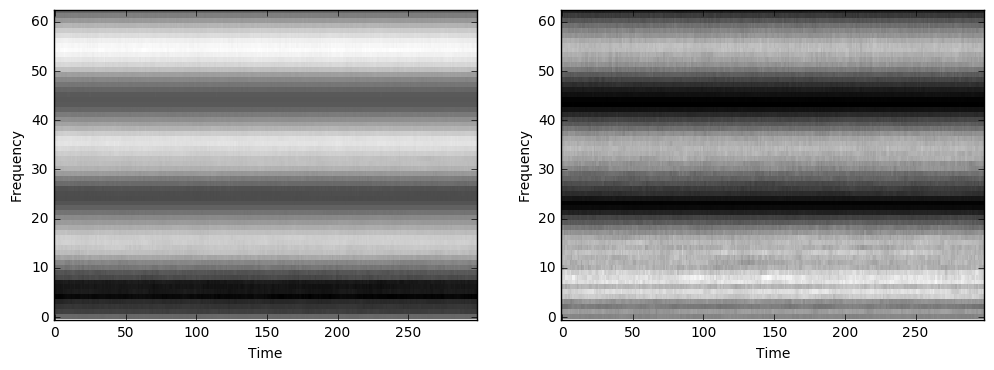

In [82]:
fig= pylab.figure( figsize=(12, 4), dpi=320,)
a=fig.add_subplot(1,2,1)
pylab.imshow(mean, origin='lower', aspect='auto', interpolation='nearest', cmap='gray')
pylab.xlabel('Time')
pylab.ylabel('Frequency')

a=fig.add_subplot(1,2,2)
pylab.imshow(std, origin='lower', aspect='auto', interpolation='nearest', cmap='gray')
pylab.xlabel('Time')
pylab.ylabel('Frequency')
pylab.show()

In [83]:
# normalize dataset
data_norm = (spectrograms-mean)/std

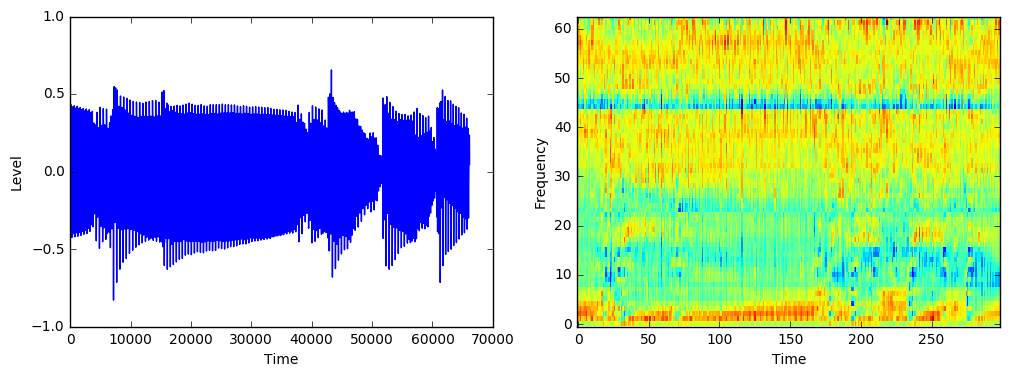

In [84]:
draw_index = 114


fig= pylab.figure( figsize=(12, 4), dpi=320,)
a=fig.add_subplot(1,2,1)
pylab.plot(chunks[draw_index])
pylab.xlabel('Time')
pylab.ylabel('Level')
pylab.ylim([-1,1])

b=fig.add_subplot(1,2,2)
pylab.imshow(data_norm[draw_index], origin='lower', aspect='auto', interpolation='nearest') #, cmap='gray')
pylab.xlabel('Time')
pylab.ylabel('Frequency')
pylab.show()

In [85]:
sample_dir ='samples1'
if not os.path.exists(sample_dir):
    os.mkdir(sample_dir)
for i, w in enumerate(data_norm):
    fig= pylab.figure( figsize=(12, 4), dpi=320,)
    a=fig.add_subplot(1,2,1)
    pylab.plot(chunks[i])
    pylab.xlabel('Time')
    pylab.ylabel('Level')
    pylab.ylim([-1,1])

    b=fig.add_subplot(1,2,2)
    pylab.imshow(data_norm[i], origin='lower', aspect='auto', interpolation='nearest', cmap='gray')
    pylab.xlabel('Time')
    pylab.ylabel('Frequency')
    
    pylab.savefig(sample_dir + "/___spectr_" + str(i))
    fig.clear()

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
